# Fake News Classifer

Projet de l'ue ML1 du groupe composé de : 
* Alexandre Cauty
* Thomas Juliat
* Loic Schnuriger
* Lucas Aissaoui

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english')) 

from MyNLPUtilities import *

[nltk_data] Downloading package wordnet to /home/oem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/oem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/oem/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Importer les données

Cette cellule contient permet d'importer les données depuis le fichier csv, on utilise "news400rows.csv" pour les test et "news.csv" contient l'intégralité des données

In [11]:
news = pd.read_csv("news8904.csv", sep=",")
#news = pd.read_csv("news400.csv", sep=",")

X = news.drop(['ratingName'], axis=1)
Y = pd.DataFrame(news['ratingName'])

# Conversion de True/False en 0/1
Y = Y['ratingName'].astype(int)

Conversion en tableau

In [12]:
X = X.to_numpy()
Y = Y.to_numpy()

# Nettoyeur de text

In [13]:
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

def MyCleanText(X, 
               lowercase=True, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres  
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=True # lematisation des termes 
              ):
    
    sentence=str(X)

    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]
    
    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
        

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]
        
    sentence= ' '.join(words)
  
    return sentence

[nltk_data] Downloading package wordnet to /home/oem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/oem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Normaliseur de text

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=True,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=True # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self  

# Premier model avec SVM

[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   6.1s
[Pipeline] .. (step 2 of 3) Processing count_vectorizer, total=   0.6s
[Pipeline]  (step 3 of 3) Processing RandomForestClassifier, total=  12.5s
Accuracy : 0.723
Classification Report
              precision    recall  f1-score   support

           0    0.74279   0.67795   0.70889      1329
           1    0.70665   0.76768   0.73590      1343

    accuracy                        0.72305      2672
   macro avg    0.72472   0.72282   0.72240      2672
weighted avg    0.72462   0.72305   0.72247      2672



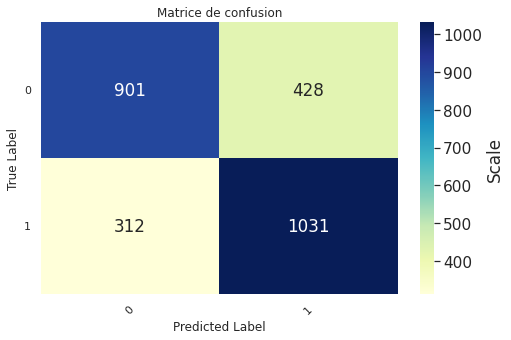

In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
import xgboost 

# Création d'un jeu d'apprentissage et de test
trainsize=0.7 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour le test

testsize= 0.3
seed=30
X_train,X_test,Y_train,Y_test=train_test_split(X, 
                                               Y, 
                                               train_size=trainsize, 
                                               random_state=seed,
                                               test_size=testsize)

# création du pipeline en ajoutant le classifier
pipe = Pipeline([("cleaner", TextNormalizer()),
                 #("count_vectorizer", CountVectorizer(stop_words='english')), #TfidfVectorizer(stop_words='english',ngram_range=(1,2)
                 ("count_vectorizer", CountVectorizer(stop_words='english', max_features=3000)),
                 #("SVC", SVC())])
                 ("RandomForestClassifier", RandomForestClassifier(max_features="sqrt",n_estimators=300))], verbose=True) # 0.711:1000  // 0.715:300 // 0.714:200 // 0.708:400
                 #("PassiveAggressiveClassifier", PassiveAggressiveClassifier())]) # 0.670
                 #("MultinomialNB", MultinomialNB())])
                 #("xgboost.XGBClassifier", xgboost.XGBClassifier(booster="gbtree", eta=0.1, max_depth=20, min_child_weight=0))])
                 #xgboost.XGBClassifier

pipe.fit(X_train,Y_train)

#from sklearn import metrics
y_pred = pipe.predict(X_test)

MyshowAllScores(Y_test,y_pred)

("SVC", SVC(kernel='poly', degree=2)) -> 0.692

# Tester plusieurs models

Objectif : Trouver le meilleur model pour un meme jeu de données. 

Dans cette cellule on importe les models pour creer les pipe

In [15]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost 

On créer en suite un tableau de model : 

In [16]:
models = [DummyClassifier, 
          LogisticRegression, 
          DecisionTreeClassifier, 
          KNeighborsClassifier,  
          SVC, 
          RandomForestClassifier,
          xgboost.XGBClassifier]

En suite on creer un tableau de pipe. Un pipe par model : 

In [17]:
pipes = []

for model in models: 
  pipes.append(Pipeline([("cleaner", TextNormalizer()), ("count_vectorizer", CountVectorizer()), ("classifier", model())]))

On lance l'entrainement : 

DummyClassifier()
Accuracy : 0.497
Classification Report
              precision    recall  f1-score   support

           0    0.49738   1.00000   0.66433      1329
           1    0.00000   0.00000   0.00000      1343

    accuracy                        0.49738      2672
   macro avg    0.24869   0.50000   0.33217      2672
weighted avg    0.24739   0.49738   0.33043      2672



/home/oem/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oem/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oem/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


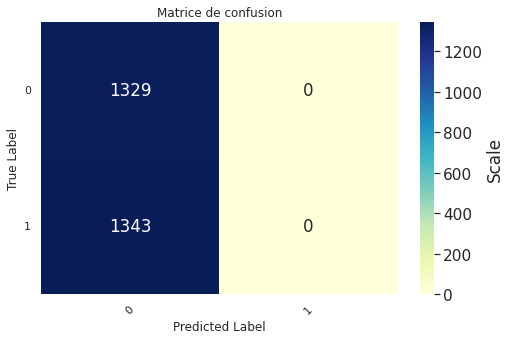

LogisticRegression()


/home/oem/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy : 0.683
Classification Report
              precision    recall  f1-score   support

           0    0.68620   0.66968   0.67784      1329
           1    0.68073   0.69695   0.68874      1343

    accuracy                        0.68338      2672
   macro avg    0.68346   0.68331   0.68329      2672
weighted avg    0.68345   0.68338   0.68332      2672



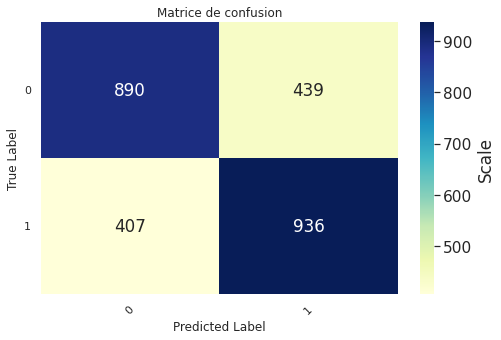

DecisionTreeClassifier()
Accuracy : 0.652
Classification Report
              precision    recall  f1-score   support

           0    0.65314   0.64184   0.64744      1329
           1    0.65154   0.66270   0.65707      1343

    accuracy                        0.65232      2672
   macro avg    0.65234   0.65227   0.65225      2672
weighted avg    0.65233   0.65232   0.65228      2672



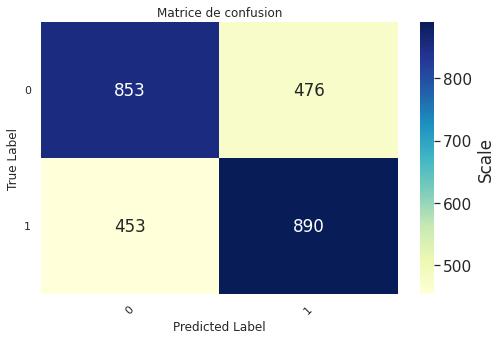

KNeighborsClassifier()
Accuracy : 0.579
Classification Report
              precision    recall  f1-score   support

           0    0.59517   0.48232   0.53283      1329
           1    0.56865   0.67535   0.61743      1343

    accuracy                        0.57934      2672
   macro avg    0.58191   0.57884   0.57513      2672
weighted avg    0.58184   0.57934   0.57535      2672



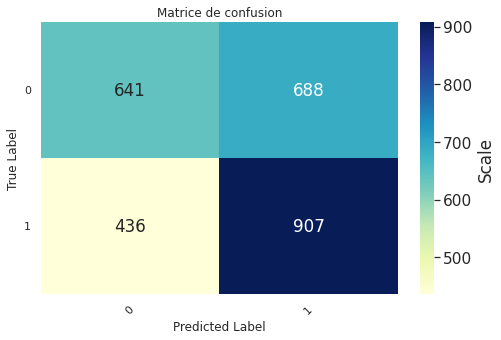

SVC()
Accuracy : 0.708
Classification Report
              precision    recall  f1-score   support

           0    0.72720   0.65989   0.69191      1329
           1    0.69168   0.75503   0.72197      1343

    accuracy                        0.70771      2672
   macro avg    0.70944   0.70746   0.70694      2672
weighted avg    0.70934   0.70771   0.70702      2672



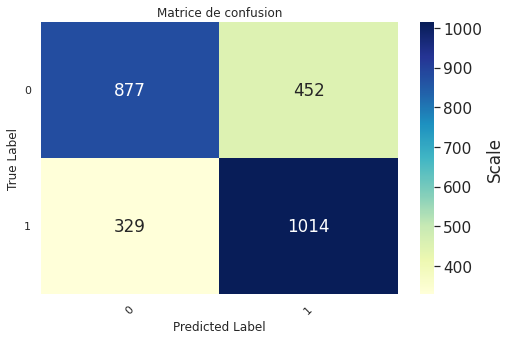

RandomForestClassifier()
Accuracy : 0.708
Classification Report
              precision    recall  f1-score   support

           0    0.71895   0.67946   0.69865      1329
           1    0.69915   0.73716   0.71765      1343

    accuracy                        0.70846      2672
   macro avg    0.70905   0.70831   0.70815      2672
weighted avg    0.70900   0.70846   0.70820      2672



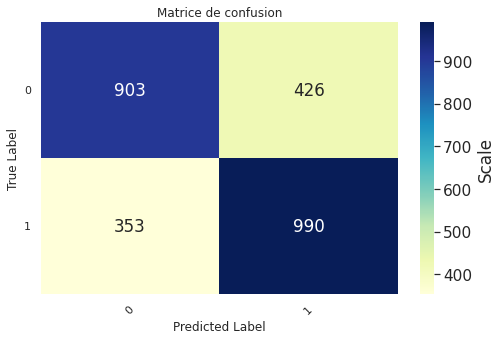

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
Accuracy : 0.693
Classification Report
              precision    recall  f1-score   support

           0    0.71945   0.62904   0.67122      1329
           1    0.67351   0.75726   0.71293      1343

    accuracy                        0.69349      2672
  

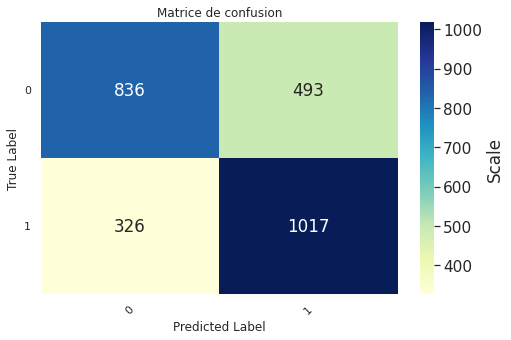

In [18]:
for pipe in pipes: 
  print(pipe["classifier"]) 
  pipe.fit(X_train,Y_train)
  y_pred = pipe.predict(X_test)
  MyshowAllScores(Y_test,y_pred)

# Visualisation de données

In [18]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
texte = news['text']

print ("Application de TfidfVectorizer :")
#vectorizer = TfidfVectorizer()
vectorizer =CountVectorizer(stop_words='english', max_features=10)
# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

#display(df)
X = df

Application de TfidfVectorizer :


In [22]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=Y) 
fig.show()